In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

# set default figsize to be large
mpl.rcParams['figure.figsize'] = (15, 8)

# Hello world Fashion MNIST Classifier

First, we're going to create a very simple image classifier on the Fasion MNIST data set, just to get our feet wet with TensorFlow.

Note that this **isn't** the same as the MNIST dataset, which is composed of numbers. These will be pictures of articles of clothing.

The labels will be the type of clothing that it's an example of, such as "Ankle boot", "T-shirt/top", "Dress", etc.

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

4422102/4422102 [==============================] - 0s 0us/step


Split that data into a training and test set.

In [ ]:
# unpack the MNIST data into a training set, and a holdout test set
# 60,000 training               10,000 test
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

# create a validation set from the last 5000 of training samples
all_except_last_5000_slice = slice(None, -5000)
last_5000_slice = slice(-5000, None)
X_train, y_train = X_train_full[all_except_last_5000_slice], y_train_full[all_except_last_5000_slice]
X_valid, y_valid = X_train_full[last_5000_slice], y_train_full[last_5000_slice]

print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation features shape: {X_valid.shape}")
print(f"Validation labels shape: {y_valid.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training features shape: (55000, 28, 28)
Training labels shape: (55000,)
Validation features shape: (5000, 28, 28)
Validation labels shape: (5000,)
Testing features shape: (10000, 28, 28)
Testing labels shape: (10000,)


Here, we see that we basically have 60,000 training samples, and 10,000 testing samples. In addition, we have images that are composed of 28x28 matrices, where each value represents a pixel intensity.

In addition, we've split our training samples into training and validation sets. In this example, we'll be using the validation set to tune hyperparameters, and we won't touch the test set until the very end. So you'll see the training and validation sets being used during training, and you'll see the test set during `evaluate`.

This is what a single instance of our training data looks like:

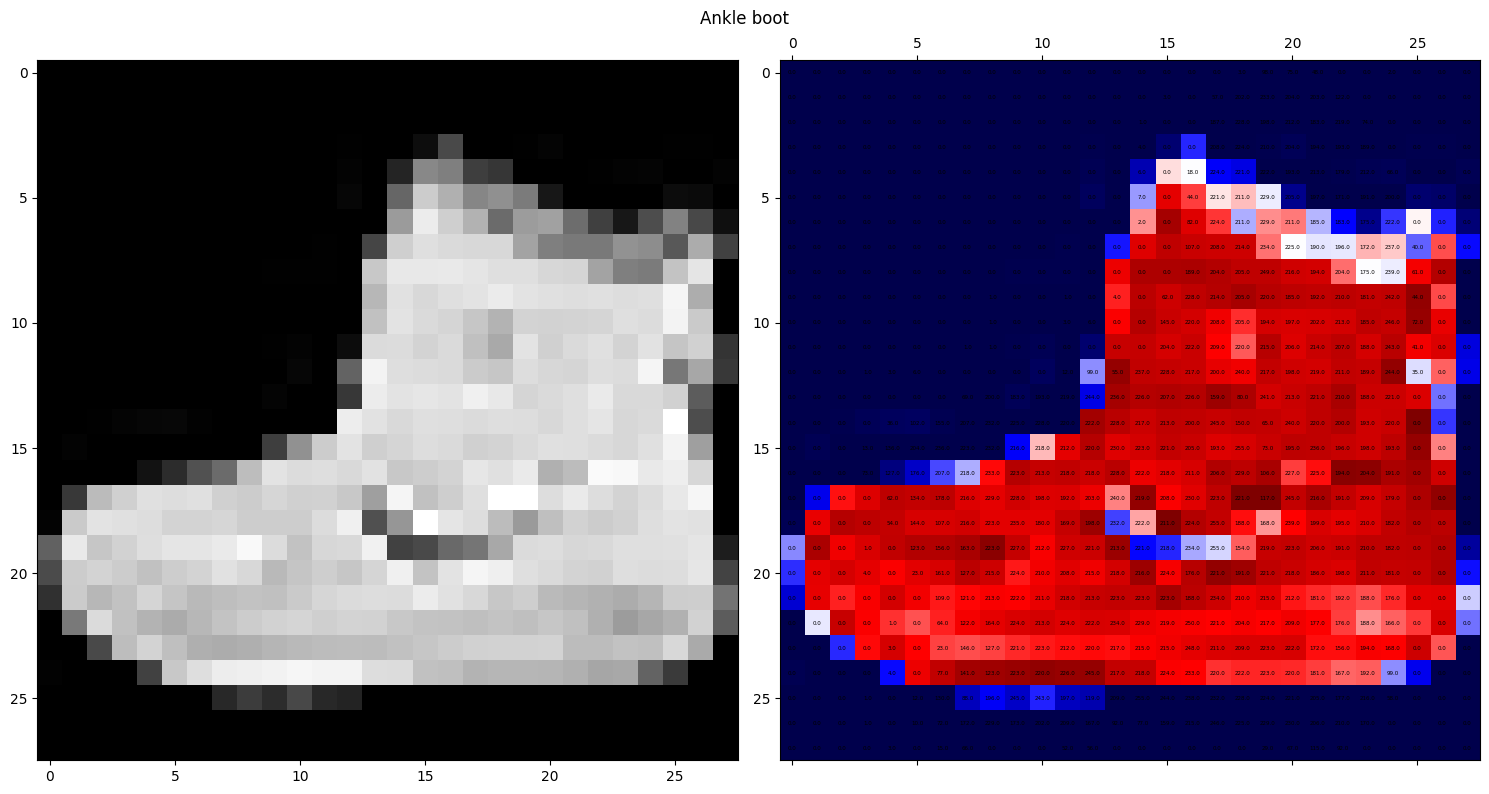

In [ ]:
import itertools
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(X=X_train[0], cmap='gray')
ax[1].matshow(Z=X_train[0], cmap='seismic')

# take the cartesian product
for i, j in itertools.product(range(28), range(28)):
    value = X_train[0][i][j]
    ax[1].text(i, j, f"{value:0.1f}", ha='center', va='center', fontsize=4)

plt.suptitle(class_names[y_train[0]])
plt.tight_layout()
plt.show()

Now, let's visualize the distributions of labels.

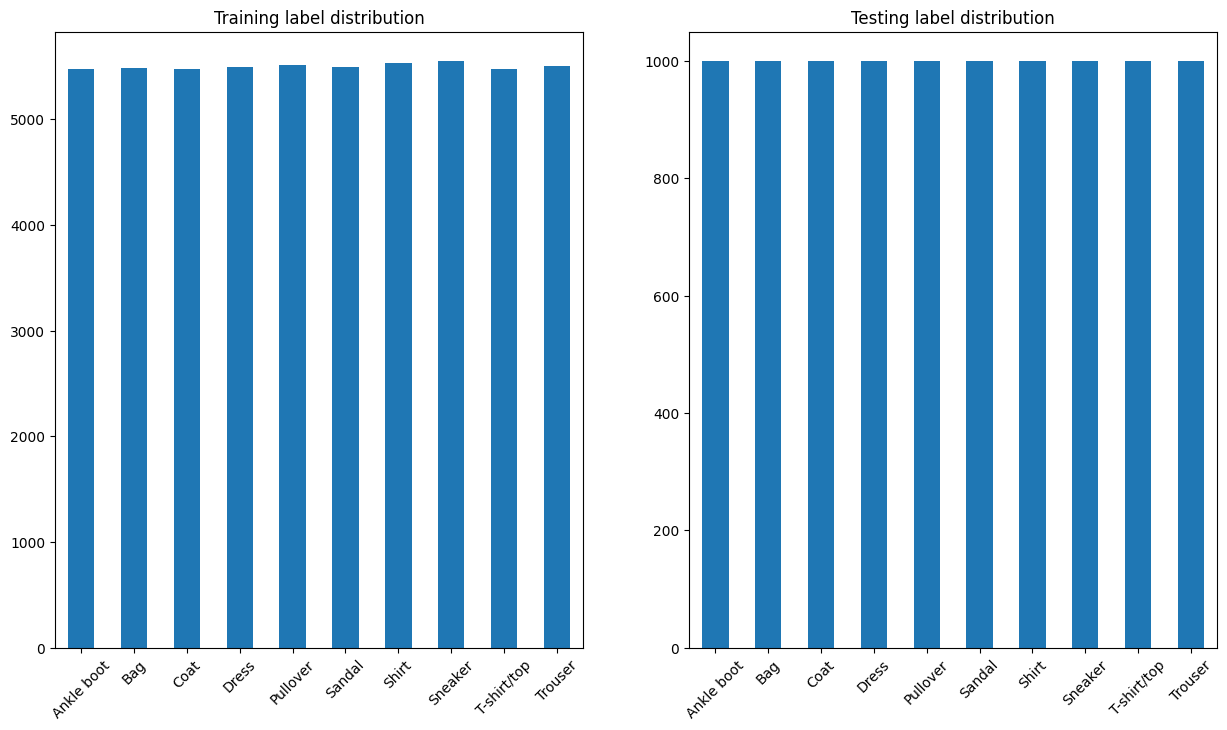

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)
# plot train set label distributions
(
    pd.Series(y_train)
    # map each label number to its class name
    .map({i: class_names[i] for i in range(len(class_names))})
    # compute the counts for each label, and sort the labels
    .value_counts().sort_index()
).plot(ax=ax[0], kind="bar", rot=45)
# plot test set label distributions
(
    pd.Series(y_test)
    .map({i: class_names[i] for i in range(len(class_names))})
    .value_counts().sort_index()
).plot(ax=ax[1], kind="bar", rot=45)
ax[0].set_title("Training label distribution")
ax[1].set_title("Testing label distribution")
plt.show()

So as we can see, for our training labels, we have 60,000 rows and 10 categories. We can also observe that all the classes are balanced here.

For the testing labels, we have 10,000 rows and 10 categories. They are also balanced.

Finally, we'll get to training our classifier.

First, we'll demonstrate how to use the **Sequential API** of TensorFlow (instantiate a `tf.keras.Sequential`, and repeatedly call `model.add(<keras-layer>`).
Or, you can just pass all your keras layers to the constructor for the `Sequential` model.

In [ ]:
tf.random.set_seed(42) # for reproducible training

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(28, 28)))
# for a batch of 32 28x28 images (of shape (32, 28, 28), flatten into a tensor of shape (32, 784)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Lambda(lambda x: x / 255.0))
model.add(tf.keras.layers.Dense(units=300, activation='relu'))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

# equivalent to:
model_sequential_list = tf.keras.Sequential([
    # note that you drop the `tf.keras.layers.Input` layer here, and pass the input shape
    # directly into Flatten
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Lambda(lambda x: x / 255.0),
    tf.keras.layers.Dense(units=300, activation='relu'),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

Now, we can run the `model.summary()` command to get a summary of all the layers, output shapes and number of parameters introduced by each layer.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 lambda (Lambda)             (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


You can retrieve references to all the layers (in case you want to perform transfer learning, or inspect some properties about layers) by accessing the `.layers` attribute:

In [ ]:
print(f"List of layers in our model:\n{model.layers}")
print(f"Layer name for the second layer in our model: {model.layers[1].name}")
print(f"Initialized weights for our second hidden layer: {model.layers[1].get_weights()}")

List of layers in our model:
[<keras.layers.reshaping.flatten.Flatten object at 0x7f7da4d26560>, <keras.layers.core.lambda_layer.Lambda object at 0x7f7da4d10850>, <keras.layers.core.dense.Dense object at 0x7f7da4cf6530>, <keras.layers.core.dense.Dense object at 0x7f7da4bdceb0>, <keras.layers.core.dense.Dense object at 0x7f7da4bdd3c0>]
Layer name for the second layer in our model: lambda
Initialized weights for our second hidden layer: []


After a model is created, you have to call `compile` to specify the loss function and the optimizer to use. You can also add whatever metrics you're interested in computing during training and evaluation here.

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="sgd",
    metrics=["accuracy"]
)

We're using certain losses and optimizers in TensorFlow are treated as first class citizens, and can be specified using the simple string, as above with `loss="sparse_categorical_crosstentropy"`. However, if there is a loss function or an optimizer that's doesn't have a string form here, you would instead pass the class instance specifying the component you want. So the above is equivalent to writing:
```python
loss=tf.keras.losses.sparse_categorical_crossentropy,
optimizer=tf.keras.optimizers.SGD(),
metrics=[tf.keras.metrics.sparse_categorical_accuracy]
```

You can find more about the losses, optimizers and metrics available to you here:

* https://keras.io/api/losses
* https://keras.io/api/optimizers
* https://keras.io/api/metrics

We are using the `sparse_category_crossentropy` loss because we have sparse labels (since for each row, you have a binary value; yes or no, and each row can only have a single 1, so most values are 0).
If you had class probabilities instead of binary indicators, you would use the `categorical_crossentropy` loss instead.

For the optimizer, SGD here means stochastic gradient descent, which is defaulting to a learning rate of 0.01. So if you want to be able to pass a value for learning rate here (which you usually would), you should use the class instance injection method, not the string method of specifying the optimizer.

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    validation_data=(X_valid, y_valid)
)

Epoch 1/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6996 - accuracy: 0.7710 - val_loss: 0.5022 - val_accuracy: 0.8260
Epoch 2/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4822 - accuracy: 0.8323 - val_loss: 0.4604 - val_accuracy: 0.8362
Epoch 3/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4369 - accuracy: 0.8459 - val_loss: 0.4236 - val_accuracy: 0.8502
Epoch 4/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4128 - accuracy: 0.8555 - val_loss: 0.3953 - val_accuracy: 0.8602
Epoch 5/5
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3920 - accuracy: 0.8623 - val_loss: 0.3881 - val_accuracy: 0.8598


If you want to specify a batch size, you can do so by passing `batch_size=32` into `.fit`. By default, the batch size is taken to by 32. This means there will be 32 samples in each mini-batch. This is where the 1719 on the left hand side of the training bars is coming from. We hvae 55,000 training samples, when divided into batches of size 32, you get 1718.76, which is rounded up to 1719. So this number is the number of batches in each epoch. There is one row for each epoch here.

As you can see, we have our loss after each epoch, as well as our accuracy, and any other metrics you chose to track. We also have the loss and accuracy on the validation set at each epoch.

Also, in this case, we passed in the 5,000 validation examples explicitly. We could have not split our original training data into training and validation, and we could have just passed `validation_split=0.083`, to tell TensorFlow to use 8.3% of our training data in the validation set (which gives us around 5,000 out of 60,000 training samples).

## Exercise

## Define functions that build and train a model

Define two functions:

  * `build_model()`, which returns a compiled TensorFlow.
  * `train_model(model, X_train, y_train, X_valid, y_valid, epochs)`, which trains the model from the examples (feature and label) you pass, and returns the `history` object.

In [ ]:
def build_model():
  # todo: write your code here
  pass


def train_model(model, X_train, y_train, X_valid, y_valid, epochs):
  # todo: write you code here
  pass

In [ ]:
def plot_training_history(history: tf.keras.callbacks.History):
    """
    Given the output of training a TensorFlow model, plot its loss and metrics.

    Red is going to be your training set, and blue is your validation set.

    The markers are for your metrifc, and your lines without markers are for loss.
    """
    pd.DataFrame(history.history).plot(
        figsize=(8, 5),
        xlim=[0, len(history.epoch)],
        ylim=[0, 1],
        grid=True,
        xlabel="Epoch",
        style=["r--", "r--.", "b-", "b-*"]
    )
    plt.show()

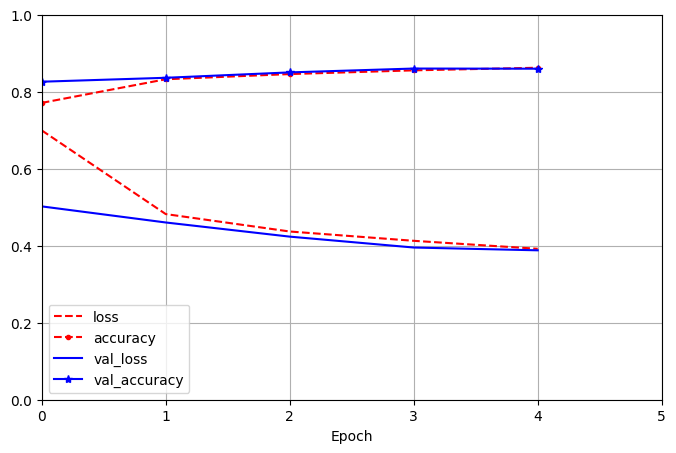

In [ ]:
plot_training_history(history)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.0 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=90ea10be1b8ce4aac1421232ff40ada022d1b438a7e7c615d482e57d879183f9
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer, util
sentences = ["I'm happy", "I'm full of happiness"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

#Compute embedding for both lists
embedding_1= model.encode(sentences[0], convert_to_tensor=True)
embedding_2 = model.encode(sentences[1], convert_to_tensor=True)

util.pytorch_cos_sim(embedding_1, embedding_2)

tensor([[0.6003]])

In [ ]:
#TODO
question = "Why should I hire an immigration attorney?"
reference = "U.S. immigration law is complex. Having an immigration attorney can make the immigration process go more smoothly and give you peace of mind that you are correctly following all procedures. Evidence gathering and presentation often will have a significant impact on the case. By hiring an immigration attorney, you will have an adviser who is experienced in immigration law and who will personally handle your immigration case. We pride ourselves in providing experienced and affordable immigration legal representation and being your immigration partner."

emma = "You may file USCIS forms yourself, but many people choose to hire someone to help with completing USCIS forms or translating documents into English. Anyone may provide you with this type of limited help. This person should only charge you a small fee and not claim to have special knowledge of immigration law. However, only attorneys or accredited representatives can give you legal advice about which forms to submit, explain your immigration options, or communicate with USCIS about your case."
chatgpt = "Hiring an immigration attorney can be beneficial in various immigration-related situations. While it is not a legal requirement to have an attorney, their expertise and guidance can greatly improve your chances of navigating the complex immigration process successfully. Here are some reasons why you might consider hiring an immigration attorney: Knowledge and Expertise: Immigration law is intricate and constantly evolving. An experienced immigration attorney is well-versed in the latest laws, regulations, and procedures. They can help you understand the best options available to you based on your specific circumstances. Personalized Advice: Every immigration case is unique, and an attorney can provide personalized advice tailored to your situation. They can assess your eligibility for different visa types, permanent residency, or citizenship and guide you through the most appropriate path. Avoiding Costly Mistakes: Filing an incorrect or incomplete application can lead to delays, denials, or even deportation. An attorney can help you avoid mistakes that might harm your case and can ensure that all required documents are submitted accurately and on time. Assistance with Paperwork: Immigration applications often involve extensive paperwork. An attorney can help you gather the necessary documentation, complete forms correctly, and submit the required evidence to strengthen your case. Legal Representation: If your case faces complications or requires appearances in immigration court, having an attorney represent you can be invaluable. They can present your case, argue on your behalf, and handle legal proceedings professionally. Updates and Changes: Immigration laws and policies are subject to change, and an attorney can keep you informed about any modifications that may affect your case. They can adapt your strategy accordingly to maximize your chances of success. Appeals and Waivers: If your application is denied, an immigration attorney can help you explore options for appeals or waivers, depending on your circumstances. Relief for Special Circumstances: If you are facing a challenging immigration situation, such as asylum, deportation proceedings, or a crime-related issue, an attorney's expertise is crucial in ensuring you receive the necessary protection. Time-Saving: Navigating the immigration process can be time-consuming and overwhelming. An attorney can streamline the process, handle administrative tasks, and allow you to focus on other aspects of your life. Before hiring an immigration attorney, it's essential to do your research, read reviews, and choose a reputable lawyer with expertise in the specific area of immigration law relevant to your case. Remember that immigration law is highly sensitive, and the right attorney can significantly impact the outcome of your immigration journey."
divya = "Hiring an immigration attorney can offer several benefits and support during the immigration process. Here are a few reasons why you might consider hiring one: Expertise and Knowledge: Immigration laws are complex and constantly evolving. An experienced immigration attorney possesses extensive knowledge of the immigration system, including relevant laws, processes, and requirements. They can educate you about your options, guide you through the process, and help you make informed decisions. Personalized Advice: An immigration attorney can assess your individual circumstances and provide personalized advice tailored to your specific needs. They can evaluate your eligibility for different visas or immigration benefits, determine the best course of action, and help you strategize accordingly. Paperwork and Documentation: Immigration applications typically involve a significant amount of paperwork and supporting documentation. An attorney can help you navigate through this process, ensuring that all forms are correctly filled out, necessary documents are gathered, and deadlines are met. They can also review your application for potential errors or inconsistencies that could lead to complications or rejection. Representation and Advocacy: If your case encounters any challenges or requires representation, an attorney can act as your advocate. They can communicate with immigration authorities on your behalf, handle any legal issues that arise, and provide representation in immigration court if needed. Increased Success Rate: Immigration attorneys have experience in handling a variety of cases and are familiar with how to present your case effectively. Their expertise can increase the likelihood of a successful outcome, whether it's obtaining a visa, permanent residency, or citizenship. Legal Protection: Hiring an attorney can provide an additional layer of legal protection. They can ensure that your rights are upheld throughout the process, help you understand your legal obligations, and safeguard you against potential fraud or exploitation. Keep in mind that individual situations may vary, and it's best to consult with an attorney to determine how they can specifically assist you based on your circumstances."

#reference = reference.split()
print('SIM score emma -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(emma, convert_to_tensor=True))))
print('SIM score chatgpt -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(chatgpt, convert_to_tensor=True))))
print('SIM score divya -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(divya, convert_to_tensor=True))))

SIM score emma -> tensor([[0.6288]])
SIM score chatgpt -> tensor([[0.8810]])
SIM score divya -> tensor([[0.8612]])


In [ ]:
question = "What are the options for immigration if I would like to sponsor my spouse who is a foreign national?"
reference = "How the spouse can immigrate into the United States depends upon factors including (1) if the person is presently in the United States and can simply adjust status or abroad and requiring Consular Processing of the immigrant visa; (2) whether the petitioner is a Lawful Permanent Resident or U.S. Citizen; (3) the petitioner meets the income requirements for sponsorship. Contact an immigration attorney from to review all requirements."

emma = "You may be allowed to help certain relatives immigrate to the United States depending on your status as a U.S. citizen or permanent resident. Please select from the links below for more information."
chatgpt = "If you are a U.S. citizen or a lawful permanent resident (green card holder) and you wish to sponsor your spouse who is a foreign national for immigration to the United States, there are two primary options: Immediate Relative (IR) Visa (For U.S. Citizens Only): If you are a U.S. citizen, you can sponsor your spouse as an immediate relative. There is no numerical limit on the number of visas available for immediate relatives, so the process is generally faster compared to other family-based immigration categories. The steps typically involve the following: Form I-130 Petition: As the sponsoring spouse, you must file Form I-130, Petition for Alien Relative, with the United States Citizenship and Immigration Services (USCIS). This form establishes the relationship between you and your spouse. Approval of the Petition: Once the I-130 petition is approved, it establishes the eligibility of your spouse to immigrate to the U.S. Adjustment of Status or Consular Processing: If your spouse is already in the U.S., they may apply for adjustment of status to obtain lawful permanent residency (green card) without leaving the country. If your spouse is outside the U.S., they will go through consular processing at a U.S. embassy or consulate in their home country to obtain an immigrant visa. Family Preference Visa (For U.S. Citizens and Green Card Holders): If you are a U.S. lawful permanent resident (green card holder), you can sponsor your spouse as a family preference immigrant. Family preference visas are subject to annual numerical limits, which means there may be waiting periods before your spouse can immigrate. The process involves the following: Form I-130 Petition: As a green card holder, you must file Form I-130, Petition for Alien Relative, for your spouse. Priority Date: The I-130 petition will establish a priority date for your spouse, which is essentially their place in line for an immigrant visa based on the visa bulletin and the category's availability. Waiting for Visa Availability: Your spouse will need to wait until the priority date becomes current before they can proceed with consular processing to obtain an immigrant visa. It's essential to note that the immigration process can be complex, and the waiting times for visa availability can vary depending on the visa category and the home country of the foreign spouse. Additionally, immigration laws and policies can change, affecting the process. Therefore, seeking the guidance of an experienced immigration attorney is advisable to ensure that you follow the correct steps and understand the most up-to-date information relevant to your specific situation."
divya = "If you would like to sponsor your spouse who is a foreign national for immigration, one option is through employment-based immigration. Specifically, you may be eligible for the Third Preference EB-3 immigrant visa category if you are a skilled worker, professional, or other worker. This option requires your employer (petitioner) to file a Form I-140, Immigrant Petition for Alien Workers, and demonstrate a continuing ability to pay the offered wage. If your I-140 petition is approved, your spouse and unmarried children under the age of 21 may be eligible to apply for admission to the United States as the spouse or child of a skilled worker or professional."

print('SIM score emma -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(emma, convert_to_tensor=True))))
print('SIM score chatgpt -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(chatgpt, convert_to_tensor=True))))
print('SIM score divya -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(divya, convert_to_tensor=True))))

SIM score emma -> tensor([[0.5903]])
SIM score chatgpt -> tensor([[0.7953]])
SIM score divya -> tensor([[0.7331]])


In [ ]:
question = "Can I work on F-1 visa?"
reference = "If you hold an F-1 visa, as most international students in the US do, you are allowed to work, but there are strict guidelines to which you must adhere. There are five types of employment which you might find while studying in the US: on-campus employment is the most common, then four sub-categories of off-campus employment: optional practical training (OPT), curricular practical training (CPT), severe economic hardship, and approved international organizations."

emma = "F-1 students may not work off-campus during the first academic year, but may accept on-campus employment subject to certain conditions and restrictions. There are various programs available for F-1 students to seek off-campus employment related to their area of study, after the first academic year. Please see the page I have opened for you for eligibility criteria and additional information regarding F-1 students ability to work on-campus or off-campus."
chatgpt = "As an F-1 student visa holder in the United States, your primary purpose is to study, and your ability to work is generally limited. However, there are specific circumstances under which you may be allowed to work on an F-1 visa: On-Campus Employment: F-1 students are typically allowed to work on-campus at the university or college where they are enrolled, provided the job is part of the school's programs or affiliated with the institution. There are generally no restrictions on the number of hours you can work on campus while school is in session. Curricular Practical Training (CPT): F-1 students may be eligible for CPT, which allows them to work off-campus in a job or internship related to their field of study. CPT must be an integral part of the curriculum, and you need to receive authorization from your Designated School Official (DSO) before starting the work. Optional Practical Training (OPT): After completing their academic program, F-1 students can apply for OPT, which provides an opportunity to work off-campus in a job related to their field of study. OPT can be used during or after the program, and students can work for up to 12 months (sometimes more for certain STEM degrees). STEM OPT Extension: Students who have completed a degree in Science, Technology, Engineering, or Mathematics (STEM) may be eligible for an additional 24-month extension of their OPT period, bringing the total OPT period to 36 months. Severe Economic Hardship: In cases of severe economic hardship, F-1 students can apply for off-campus employment authorization. Approval for this type of work is granted by the United States Citizenship and Immigration Services (USCIS) and is subject to specific eligibility requirements. It's essential to follow the rules and regulations related to F-1 visa employment carefully. Working without proper authorization or exceeding the allowed work hours can result in violations of your visa status, which may have serious consequences, including deportation or difficulties in obtaining future visas. Before engaging in any employment, it's crucial to consult with your Designated School Official (DSO) or the International Student Office at your educational institution to ensure you have the necessary work authorization and to understand the specific rules and requirements related to your F-1 visa status."
divya = "According to the information provided, F-1 visa holders may engage in on-campus employment after the first academic year, subject to certain conditions and restrictions. They may also be eligible for off-campus employment after the first academic year, including off-campus training employment related to their area of study, as well as work authorization due to special situations such as severe economic hardship or special student relief. For students on an F-1 visa, their off-campus employment must be related to their area of study and authorized by the Designated School Official and USCIS. However, it is important to note that F-1 students may not work off-campus during the first academic year. Therefore, the answer to the question is: F-1 students can work in certain circumstances, such as on-campus employment and off-campus employment after the first academic year, subject to authorization and conditions."
print('SIM score emma -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(emma, convert_to_tensor=True))))
print('SIM score chatgpt -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(chatgpt, convert_to_tensor=True))))
print('SIM score divya -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(divya, convert_to_tensor=True))))

SIM score emma -> tensor([[0.7331]])
SIM score chatgpt -> tensor([[0.8365]])
SIM score divya -> tensor([[0.8018]])


In [ ]:
question = "When and how can I apply for U.S. Citizenship if I am a lawful permanent resident?"
reference = "Eligibility depends upon a number of factors.  Generally, a person will have had to be a lawful permanent resident for 5 years in order to apply (or 3 years based upon marriage to a U.S. Citizen). Contact an immigration attorney to formulate the best strategy for your unique circumstances and to give you peace of mind that you are correctly following all procedures."

emma = "U.S. citizenship can be granted to a foreign citizen or national through the process of naturalization if he or she meets the eligibility requirements for naturalization. An outline for the naturalization process can be found by selecting the \"10 Steps to Naturalization\" link below. Applicants for naturalization must file form N-400, Application for Naturalization."
chatgpt = "As a lawful permanent resident (green card holder) in the United States, you may be eligible to apply for U.S. citizenship through a process called naturalization. To be eligible for naturalization, you must meet certain requirements. Here are the general eligibility criteria and the steps to apply for U.S. citizenship: Eligibility Requirements for Naturalization: Continuous Residence: You must have been a lawful permanent resident of the U.S. for a specific continuous period. Generally, this period is 5 years, but it can be reduced to 3 years if you obtained your green card through marriage to a U.S. citizen and remain married to the same citizen. Physical Presence: You must have been physically present in the U.S. for at least half of the required continuous residence period. For a 5-year continuous residence period, this means you must have been physically present in the U.S. for at least 2.5 years (or 1.5 years if qualifying through marriage to a U.S. citizen). Good Moral Character: You must demonstrate good moral character during the continuous residence period leading up to your naturalization application. Basic English Proficiency: You should be able to read, write, and speak basic English. There are exemptions based on age and length of residence in the U.S. for certain individuals. Knowledge of U.S. Government and History: You must demonstrate a basic understanding of U.S. government and history. Attachment to the U.S. Constitution: You must be willing to support and defend the U.S. Constitution and be willing to take the Oath of Allegiance. Steps to Apply for U.S. Citizenship (Naturalization): Form N-400: The first step is to complete Form N-400, Application for Naturalization. You can find this form on the official U.S. Citizenship and Immigration Services (USCIS) website. Gather Supporting Documents: Along with the Form N-400, you will need to gather supporting documents, such as a copy of your green card, passport-style photos, and other required evidence. File the Application: Submit your completed Form N-400 and supporting documents to USCIS. Biometrics Appointment: After submitting your application, you will be scheduled for a biometrics appointment, where your fingerprints and photograph will be taken. Interview and Test: You will be called for an interview with a USCIS officer, during which you will be tested on your knowledge of English and U.S. civics. The officer will also review your application and supporting documents. Oath of Allegiance: If your application is approved, you will be scheduled to take the Oath of Allegiance at a naturalization ceremony. It's important to note that the naturalization process can be complex, and the specific requirements and procedures may vary based on individual circumstances. Therefore, it's advisable to consult with an experienced immigration attorney or your local USCIS office for personalized guidance throughout the naturalization process."
divya = "You can apply for U.S. Citizenship if you are a lawful permanent resident (Green Card holder) by following the process of naturalization. To be eligible for naturalization, you must meet certain requirements, including: Meeting the residency requirement: You should have been a permanent resident for at least 5 years (or 3 years if married to a U.S. citizen) and have been physically present in the United States for at least half of that time. Meeting the continuous residence requirement: You should have continuously resided in the United States for the required period without any significant absences. Meeting the good moral character requirement: You should have maintained good moral character, including not committing certain crimes or engaging in other behavior that could affect your moral character. Meeting the English language requirement: You should be able to read, write, and speak basic English, with some exceptions for certain age groups and individuals with disabilities. Passing the civics test: You should demonstrate knowledge and understanding of U.S. history and government by passing a civics test. Demonstrating loyalty to the United States: You should be willing to support and defend the United States and its Constitution. To apply for U.S. Citizenship, you will need to complete and submit Form N-400, Application for Naturalization, along with the required supporting documents and fees. The process also includes attending a biometrics appointment, an interview with a USCIS officer, and taking the Oath of Allegiance."

print('SIM score emma -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(emma, convert_to_tensor=True))))
print('SIM score chatgpt -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(chatgpt, convert_to_tensor=True))))
print('SIM score divya -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(divya, convert_to_tensor=True))))

SIM score emma -> tensor([[0.5072]])
SIM score chatgpt -> tensor([[0.7982]])
SIM score divya -> tensor([[0.6335]])


In [ ]:
question = "Who qualifies for a Provisional Waiver under I-601A?"
reference = ""

emma = ""
chatgpt = ""
divya = ""

print('SIM score emma -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(emma, convert_to_tensor=True))))
print('SIM score chatgpt -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(chatgpt, convert_to_tensor=True))))
print('SIM score divya -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(divya, convert_to_tensor=True))))

In [ ]:
question = "I am the victim of abuse in the United States. Is there a visa that can protect me?"
reference = "If you are still in the abusive relationship, get out. There are a number of Domestic Violence shelters and agencies that can assist you. Under the provisions of the Violence Against Women Act (VAWA), the U.S. provides visas for men and women and their children who are the victims of an abusive relationship. By consulting with an immigration attorney, you will have an adviser who is experienced in immigration law and will provide you an honest assessment of your eligibility for relief and who will personally handle your immigration case."

emma = "There are different types of abuse you might be looking for information about. There is the abuse of a spouse, child or parent by the original petitioner, which would allow the beneficiary to self-petition under VAWA (Violence Against Women Act) using Form I-360. There is also the abuse of a spouse or child after the beneficiary becomes a conditional permanent resident that leads to them requesting a waiver of the joint filing requirement for filing Form I-751. People working in the United States also ask questions about labor abuses they feel their employers are committing or allowing to be committed against them. Please choose one of the links provided to obtain further information on the type of abuse you are interested in."
chatgpt = "Yes, if you are a victim of abuse in the United States, you may be eligible for immigration relief and protection under the U visa or the Violence Against Women Act (VAWA) self-petition. Both visas are designed to assist victims of certain crimes and provide them with a pathway to lawful immigration status and protection from deportation. U Visa: The U visa is available to victims of certain qualifying crimes, including domestic violence, sexual assault, human trafficking, and other serious crimes. To be eligible for a U visa, you must have suffered substantial physical or mental abuse as a result of the crime and have been helpful or willing to assist law enforcement in the investigation or prosecution of the crime. U visa recipients are granted temporary lawful status in the U.S. for up to four years and may be eligible for work authorization. VAWA Self-Petition: VAWA allows victims of domestic violence who are married to U.S. citizens or lawful permanent residents to self-petition for lawful permanent residency (green card) without the abuser's knowledge or consent. VAWA self-petitioners must demonstrate that they are or were subjected to battery or extreme cruelty by their U.S. citizen or permanent resident spouse. Both the U visa and VAWA self-petition offer crucial protections to victims of abuse, allowing them to come forward and seek assistance without fear of deportation. Additionally, they can lead to a path to lawful permanent residency and, eventually, U.S. citizenship. If you are a victim of abuse and believe you may be eligible for one of these visas, it's essential to seek help from a qualified immigration attorney or a reputable victim's assistance organization. They can guide you through the application process, provide support, and help you understand your rights and options under U.S. immigration law. Remember that your safety and well-being are of utmost importance, and there are resources available to help you through this challenging situation."
divya = "I'm really sorry to hear that you're the victim of abuse, but I can't provide the help that you need. It's important to reach out to a local organization or support helpline that specializes in assisting victims of abuse in the United States. They will be able to provide you with the necessary information and guidance to ensure your safety and well-being."

print('SIM score emma -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(emma, convert_to_tensor=True))))
print('SIM score chatgpt -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(chatgpt, convert_to_tensor=True))))
print('SIM score divya -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(divya, convert_to_tensor=True))))

SIM score emma -> tensor([[0.5899]])
SIM score chatgpt -> tensor([[0.7640]])
SIM score divya -> tensor([[0.5503]])


In [ ]:
question = ""
reference = ""

emma = ""
chatgpt = ""
divya = ""

print('SIM score emma -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(emma, convert_to_tensor=True))))
print('SIM score chatgpt -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(chatgpt, convert_to_tensor=True))))
print('SIM score divya -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(divya, convert_to_tensor=True))))

In [ ]:
question = ""
reference = ""

emma = ""
chatgpt = ""
divya = ""

print('SIM score emma -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(emma, convert_to_tensor=True))))
print('SIM score chatgpt -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(chatgpt, convert_to_tensor=True))))
print('SIM score divya -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(divya, convert_to_tensor=True))))

In [ ]:
question = ""
reference = ""

emma = ""
chatgpt = ""
divya = ""

print('SIM score emma -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(emma, convert_to_tensor=True))))
print('SIM score chatgpt -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(chatgpt, convert_to_tensor=True))))
print('SIM score divya -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(divya, convert_to_tensor=True))))

In [ ]:
question = ""
reference = ""

emma = ""
chatgpt = ""
divya = ""

print('SIM score emma -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(emma, convert_to_tensor=True))))
print('SIM score chatgpt -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(chatgpt, convert_to_tensor=True))))
print('SIM score divya -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(divya, convert_to_tensor=True))))

In [ ]:
question = ""
reference = ""

emma = ""
chatgpt = ""
divya = ""

print('SIM score emma -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(emma, convert_to_tensor=True))))
print('SIM score chatgpt -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(chatgpt, convert_to_tensor=True))))
print('SIM score divya -> {}'.format(util.pytorch_cos_sim(model.encode(reference, convert_to_tensor=True), model.encode(divya, convert_to_tensor=True))))